In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('../data/ner_dataset.csv', encoding='latin1')

In [4]:
# fill NaN
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


Essential info about entities:

    geo = Geographical Entity
    org = Organization
    per = Person
    gpe = Geopolitical Entity
    tim = Time indicator
    art = Artifact
    eve = Event
    nat = Natural Phenomenon

In [6]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [7]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
n_words = len(words)
n_words

35179

In [8]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

So we have 47959 sentences containing 35178 different words with 17 different tags. We use the SentenceGetter class from last post to retrieve sentences with their labels.

In [10]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(data)

In [12]:
sent = getter.get_next()

In [13]:
sent

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [14]:
# get all sentences
sentences = getter.sentences

# Prepare the data

In [15]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


In [16]:
word2idx["Obama"]

27775

In [19]:
tag2idx

{'B-art': 15,
 'B-eve': 12,
 'B-geo': 1,
 'B-gpe': 4,
 'B-nat': 6,
 'B-org': 3,
 'B-per': 9,
 'B-tim': 11,
 'I-art': 16,
 'I-eve': 7,
 'I-geo': 8,
 'I-gpe': 14,
 'I-nat': 10,
 'I-org': 2,
 'I-per': 13,
 'I-tim': 0,
 'O': 5}

Now we map the senctences to a sequence of numbers and then pad the sequence. Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the mask_zeor parameter of the embedding layer to ignore inputs with value zero.

In [20]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [21]:
# example 0
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [65]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [23]:
X[0]

[19597,
 7447,
 1877,
 20272,
 10995,
 3342,
 29997,
 32881,
 23600,
 15051,
 14097,
 14656,
 5517,
 956,
 6826,
 15051,
 3381,
 7447,
 31999,
 29949,
 32499,
 12449,
 22137,
 22082]

In [26]:
word2idx['ENDPAD']

35179

In [64]:
for i, item in enumerate(word2idx.items()):
    print(item)
    if i > 3:
        break

('announce', 1)
('ramming', 2)
('Jewelry', 3)
('Richard', 4)
('compel', 5)


In [40]:
for key, value in word2idx.items():
    if value == 35178:
        print(key)

Sainovic


In [25]:
n_words - 1

35178

In [60]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [61]:
X[0]

array([19597,  7447,  1877, 20272, 10995,  3342, 29997, 32881, 23600,
       15051, 14097, 14656,  5517,   956,  6826, 15051,  3381,  7447,
       31999, 29949, 32499, 12449, 22137, 22082, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178], dtype=int32)

And we need to do the same for our tag sequence.

In [29]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [30]:
y[0]

[5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5]

In [31]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [32]:
y[0]

array([5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

For training the network we also need to change the labels y to categorial.

In [33]:
from keras.utils import to_categorical

In [34]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [35]:
y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

We split in train and test set.

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

# Setup the CRF-LSTM

Now we can fit a LSTM-CRF network with an embedding layer.

In [38]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [41]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="tanh"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [43]:
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 223s 6ms/step - loss: 0.1072 - acc: 0.9716 - val_loss: 0.0408 - val_acc: 0.9863
Epoch 2/5
38846/38846 [==============================] - 207s 5ms/step - loss: 0.0317 - acc: 0.9887 - val_loss: 0.0283 - val_acc: 0.9893
Epoch 3/5
38846/38846 [==============================] - 201s 5ms/step - loss: 0.0237 - acc: 0.9906 - val_loss: 0.0245 - val_acc: 0.9901
Epoch 4/5
38846/38846 [==============================] - 198s 5ms/step - loss: 0.0204 - acc: 0.9915 - val_loss: 0.0229 - val_acc: 0.9904
Epoch 5/5
38846/38846 [==============================] - 197s 5ms/step - loss: 0.0185 - acc: 0.9921 - val_loss: 0.0222 - val_acc: 0.9906


In [78]:
hist = pd.DataFrame(history.history)

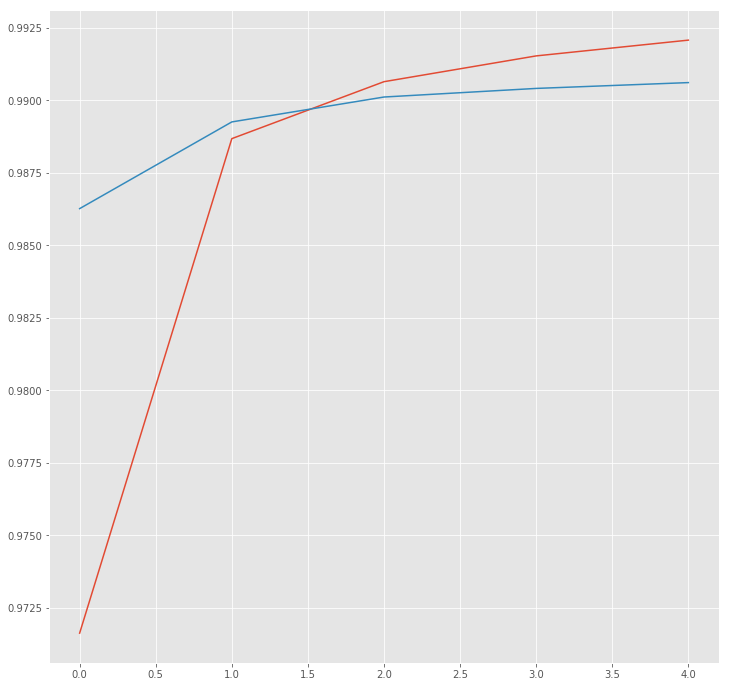

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

# Now look at some predictions.


In [45]:
i = 1927
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

In [70]:
idx2word = {value: key for key, value in word2idx.items()}

In [69]:
' '.join([idx2word[inx] for inx in X_te[i] if inx!=35178])

"Mr. Mubarak won Wednesday 's election with 88 percent of the vote ."

In [48]:
X_te[i]

array([ 3953,  3877, 15051,   995, 24820, 22428, 26839, 12703, 26645,
        3479, 31030, 11221,  5933,  6612, 13575,   956,  9816, 19725,
       19498,  6420, 26426, 27877, 20606, 13575, 22082, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178], dtype=int32)

In [71]:
idx2tag = {value: key for key, value in tag2idx.items()}

In [73]:
idx2tag

{0: 'I-tim',
 1: 'B-geo',
 2: 'I-org',
 3: 'B-org',
 4: 'B-gpe',
 5: 'O',
 6: 'B-nat',
 7: 'I-eve',
 8: 'I-geo',
 9: 'B-per',
 10: 'I-nat',
 11: 'B-tim',
 12: 'B-eve',
 13: 'I-per',
 14: 'I-gpe',
 15: 'B-art',
 16: 'I-art'}

In [77]:
' '.join([idx2tag[inx] for inx in np.argmax(y_te[i], -1)])

'B-per I-per O B-tim O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O'

In [51]:
y_te[i].shape

(75, 17)

In [50]:
np.argmax(y_te[i], -1)

array([1, 5, 5, 1, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5])

In [81]:
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Mr.            : B-geo B-geo
Mubarak        : O     O
won            : O     O
Wednesday      : B-geo B-geo
's             : I-geo I-geo
election       : O     O
with           : O     O
88             : O     O
percent        : O     O
of             : O     O
the            : O     O
vote           : O     O
.              : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic       : O     O
Sainovic 